#### Proceso de scraping

En primer lugar comenzamos definiendo el objeto reddit, y realizamos una serie de pruebas para empezar a scrappear la informacion de reddit.

In [1]:
from time import sleep

In [2]:
import praw

# Configura tu conexión con Reddit
reddit = praw.Reddit(
    client_id="XEVqTpGA9HE6MNujQAWt1w",
    client_secret="bv4J3usOH-V__I4tGD__bLoWnGA_Sg",
    user_agent="Testing_api",
    read_only=True
)



ModuleNotFoundError: No module named 'praw'

Buscamos en el subreddit de 'flat earth' y vemos los resultados.


In [ ]:
# Define el subreddit y la búsqueda
subreddit_name = "flatearth"

queries_list = [
    "flat earth",
]

resultados_totales = set()

subredit = reddit.subreddit(subreddit_name)

# Realiza la búsqueda en el subreddit
for query in queries_list:
    print(f"Buscando en el subreddit {subreddit_name} con la consulta '{query}'")
    resultados = subredit.search(query, limit=100)
    
    # Itera sobre los resultados
    for submission in resultados:
        # Verifica si el título ya está en los resultados totales
        if submission.title not in resultados_totales:
            resultados_totales.add(submission)

Buscando en el subreddit flatearth con la consulta 'flat earth'


Una vez realizamos la consulta, vemos la información que tenemos de cada post para ver cómo relacionar los nodos y estructurar el grafo.

In [ ]:
#Tomamos el primer post de los resultados

post = list(resultados_totales)[0]

In [ ]:
# Extraer el título y el contenido del post asi como el nombre del autor

print(f"Title: {post.title}")
print(f"Author: {post.author}")
print(f"Content: {post.selftext}")
print(f"URL: {post.url}")
print(f"Upvotes: {post.ups}")
print(f"Downvotes: {post.downs}")
print(f"Comments: {post.num_comments}")
print(f"Created: {post.created}")
print(f"Subreddit: {post.subreddit}")
print(f"Post ID: {post.id}")
print(f"Post URL: {post.url}")
print(f"Post Score: {post.score}")

print('\n\n')

#Navegar el arbol de comentarios
comentarios = post.comments

comentario = comentarios[0]
print(f"Comentario: {comentario.body}")
print(f"Autor: {comentario.author}")
print(f"Upvotes: {comentario.ups}")
print(f"Downvotes: {comentario.downs}")
print(f"Created: {comentario.created}")
print(f"Comentario ID: {comentario.id}")
print(f"Comentario URL: {comentario.permalink}")
print(f"Comentario Score: {comentario.score}")

Title: Research “flat earth” 
Author: Lorenofing
Content: 
URL: https://i.redd.it/30o3wt2mr9bd1.jpeg
Upvotes: 230
Downvotes: 0
Comments: 140
Created: 1720433338.0
Subreddit: flatearth
Post ID: 1dy58jz
Post URL: https://i.redd.it/30o3wt2mr9bd1.jpeg
Post Score: 230



Comentario: It definitely works as a coaster/beermat. I want one.
Autor: CoolNotice881
Upvotes: 47
Downvotes: 0
Created: 1720435000.0
Comentario ID: lc68akj
Comentario URL: /r/flatearth/comments/1dy58jz/research_flat_earth/lc68akj/
Comentario Score: 47


### Extracción de publicaciones y comentarios desde la API de Reddit

Al consultar la API obtenemos, en un solo lote, toda la información de cada publicación y de sus comentarios: incluso los “hilos” anidados aparecen aplanados en una lista única, lo que facilita procesarlos sin navegar por una estructura de árbol.

---

#### Limitaciones y retos

1. **Máximo de 100 publicaciones por consulta**  
   La API solo devuelve hasta 100 posts en cada llamada. Si necesitamos más, debemos encadenar varias consultas y combinar sus resultados manualmente.

2. **Límite de peticiones por segundo**  
   Reddit restringe la frecuencia de llamadas: demasiadas peticiones en corto tiempo pueden provocar bloqueos temporales. Es imprescindible espaciar las consultas (por ejemplo, con `time.sleep()`) o gestionar un backoff automático.

3. **Posibles duplicados**  
   Al hacer varias consultas (por fecha, por palabra clave, etc.), podemos recuperar el mismo post varias veces. Hay que implementar un filtro que descarte identificadores repetidos.

4. **Ruido y contenido irrelevante**  
   Memes, publicaciones bromistas o comentarios sin sustancia pueden contaminar el análisis. Para centrarnos en usuarios realmente convencidos, es útil definir términos clave o patrones de búsqueda que apunten a debates serios.

---

#### Estrategia sugerida

Una manera eficaz de sortear estas limitaciones es:

1. **Definir una lista de palabras clave**  
   Representativas del tema (p. ej. “terrabrain”, “climate hoax”, “antivax”).

2. **Ejecutar una consulta por cada término**  
   Recuperando hasta 100 posts en cada ronda.

3. **Unir todos los resultados**  
   En una sola colección, eliminando duplicados por ID.

4. **Aplicar un pequeño retardo**  
   Entre peticiones para respetar el límite de la API.

5. **Filtrar el contenido final**  
   - Buscar solo publicaciones que contengan varias de esas palabras clave.  
   - O bien establecer un umbral mínimo de upvotes, para quedarnos con interacciones de mayor relevancia.

De este modo, ampliamos la cobertura más allá de 100 posts, reducimos el ruido y evitamos bloqueos por exceso de llamadas.


In [ ]:
%pip install networkx matplotlib.pyplot tqdm

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


#### Definición de funciones para extraer datos de Reddit y construir el grafo

Vamos a definir una serie de funciones que nos permitan:

1. Recuperar la información relevante desde la API de Reddit (publicaciones, comentarios, autores, etc.).  
2. Procesar esos datos para identificar entidades (usuarios, subreddits) y sus relaciones.  
3. Almacenar todo en un grafo utilizando la librería **networkx**, donde cada nodo representará un usuario o un subreddit y cada arista reflejará una interacción.

In [ ]:
def get_results(subreddit, query_list, n_post = 10):
    resultados_totales = set()
    
    subredit = reddit.subreddit(subreddit)
    
    for query in query_list:
        print(f"Buscando en el subreddit {subreddit} con la consulta '{query}'")
        
        try:
        
            resultados = subredit.search(query, limit=n_post)
            
            for submission in resultados:
                # Verifica si el título ya está en los resultados totales
                if submission.title not in resultados_totales:
                    resultados_totales.add(submission)
                    
        except Exception:
            continue
                
    return resultados_totales


##### Función `scrapear_subreddit`

Esta función extrae información de un subreddit y la convierte en un grafo de interacciones entre usuarios y el propio subreddit.

1. **Obtener posts**  
   Llama a `get_results(subreddit, query_list, n_post)` para recuperar hasta `n_post` publicaciones que coincidan con las palabras clave de `query_list`.

2. **Crear nodo de subreddit**  
   Añade el nombre del subreddit como **nodo raíz** en el grafo.

3. **Procesar cada publicación**  
   Para cada `post` obtenido:
   - Si existe autor, lo añade como nodo y crea una arista entre el subreddit y el autor.
   - Descarga **todos** los comentarios (gestionando posibles errores de rate limit).
   - Ordena los comentarios por `score` (de mayor a menor).
   - Si se especifica `max_comments`, recorta la lista a ese número.

4. **Construir conexiones entre usuarios**  
   Para cada comentario seleccionado:
   - Añade al autor del comentario como nodo (si no estaba).
   - Crea una arista **directa** entre el autor del post y el autor del comentario (sin duplicados).

---

**Resumen:**  
`scapear_subreddit` construye un grafo donde:
- **Nodos** = subreddits y usuarios.  
- **Aristas** = interacción (quién publica en qué subreddit, quién comenta los posts de quién).  
Esto permite visualizar y analizar la red de conversaciones dentro de un subreddit.  

In [ ]:
def scrapear_subreddit(subreddit, query_list, n_post = 10, max_comments = None):
    
    # Obtener los resultados
    resultados_totales = get_results(subreddit, query_list, n_post)

    # Agregar nodo raíz al grafo
    grafo.add_node(subreddit)
    
    # Agregar los nodos y aristas al grafo
    for post in tqdm(list(resultados_totales)):
        if post.author:
            grafo.add_node(post.author.name,subreddit=subreddit)
            grafo.add_edge(subreddit, post.author.name)
            
        while True:
            try:
                post.comments.replace_more(limit=None)
                break
            except Exception:
                print('demasiadas peticiones')
                sleep(10)
            
        comentarios = sorted(post.comments.list(), key=lambda x: x.score, reverse=True)
        
        for comentario in comentarios:
            if comentario.author:
                #comprueba que el nodo ya existe
                if grafo.has_node(comentario.author.name):
                    if not grafo.has_edge(post.author.name, comentario.author.name):
                        grafo.add_edge(post.author.name, comentario.author.name)
                        
        if max_comments is not None:
            comentarios = comentarios[:max_comments]
        
        for comentario in comentarios:
            if comentario.author:
                grafo.add_node(comentario.author.name, subreddit=subreddit)
                #comprobar que no exista ya la arista
                if not grafo.has_edge(post.author.name, comentario.author.name):
                    grafo.add_edge(post.author.name, comentario.author.name)

De esta forma podemos tomar información de un subreddit en función de las palabras clave de la lista, guardándolas en un grafo después.

In [ ]:
# Probamos entonces nuestra funcion de scrapping.
grafo = nx.Graph()

scrapear_subreddit('flatearth', ['flatearth'], n_post = 10)
scrapear_subreddit('antivaccine', ['antivaccine'], n_post = 10)


Buscando en el subreddit flatearth con la consulta 'flatearth'


 10%|█         | 1/10 [00:06<01:01,  6.83s/it]


KeyboardInterrupt: 

Numero de nodos: 1553
Numero de aristas: 1654
Numero de componentes: 2
Promedio de grado: 2.130070830650354
Promedio de clustering: 0.0020872147617880593


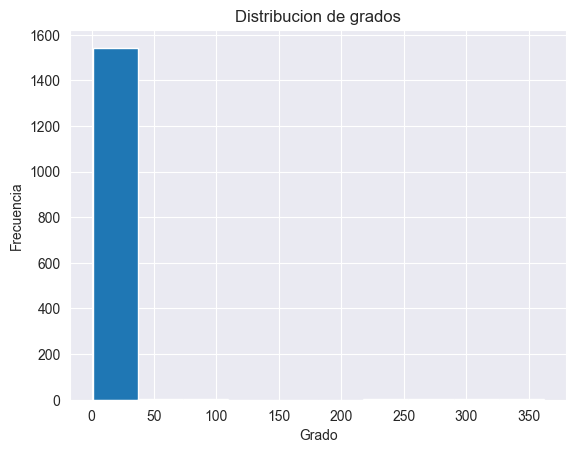

In [ ]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

# Y un histograma de la distribucion de grados

plt.hist([grafo.degree(nodo) for nodo in grafo.nodes()])
plt.xlabel('Grado')
plt.ylabel('Frecuencia')
plt.title('Distribucion de grados')
plt.show()


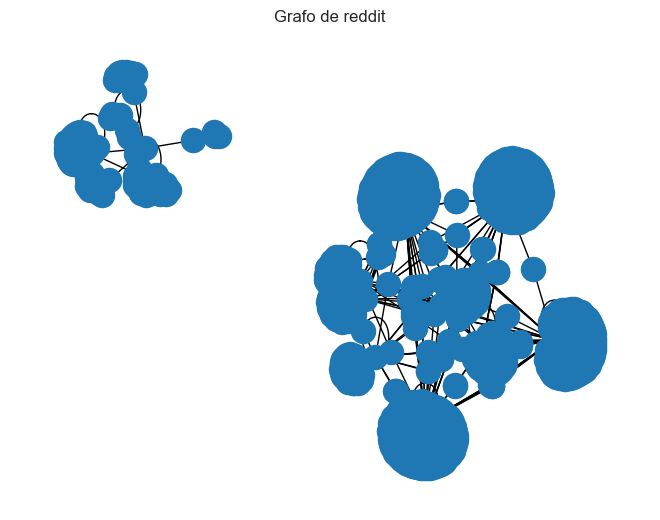

In [ ]:
# Vamos a ver el grafo

nx.draw(grafo)
plt.title('Grafo de reddit')
plt.show()

In [ ]:
#exporta el grafo a un archivo GML

nx.write_gml(grafo, "grafo.gml")

#### Preparando las queries para el grafo definitivo.

Buscamos los subreddit que nos puedan ayudar a resolver nuestra hipótesis, además de palabras clave que diferencien a los usuarios creyentes de los que no lo son. Utilizaremos algunas comunes y otras específicas del tema para afinar mejor.

Abarcamos desde creencias más inofensivas como la de la existencia de aliens o la tierra plana hasta otras más controvertidas y peligrosas como la de las vacunas.

In [ ]:
lista_comunes = ["critical thinking", "question everything", "pseudoscience",  "debunk", "denial", "conspiracy"]

subreddit_keywords = {
    'FlatEarth': [
        'flat earth theory',
        'ice wall discovery',
        'antarctic cover‑up',
        'horizon anomaly',
        'ground is level',
        *lista_comunes
    ],
    'moonlandinghoax': [
        'fake lunar mission',
        'studio filmed moon',
        'camera glitch proof',
        'lunar module lies',
        'NASA backlot conspiracy',
        *lista_comunes
    ],
    'aliens': [
        'ufo disclosure',
        'area 51 secrets',
        'extraterrestrial visit',
        'crop circle proof',
        'alien cover‑up',
        *lista_comunes
    ],
    'No5G': [
        '5g health risks',
        'radiation cover‑up',
        'cell tower danger',
        'electromagnetic fraud',
        'hidden toxicity',
        *lista_comunes
    ],
    'chemtrails': [
        'chemical spraying',
        'aerosol cover‑up',
        'geoengineering proof',
        'toxics in sky',
        'secret air program',
        *lista_comunes
    ],
    'antiVaxx': [
        'big pharma lies',
        'vaccine injury cover‑up',
        'unreported side effects',
        'injection fraud',
        'medical experimentation',
        *lista_comunes
    ],
    'pesticideconspiracy': [
        'pesticide runoff cover‑up',
        'agrochemical conspiracy',
        'glyphosate danger',
        'farmers whistleblower',
        'toxic crop spraying',
        *lista_comunes
    ],
    'CovidConspiracy': [
        'plandemic proof',
        'virus lab leak cover‑up',
        'mask mandate fraud',
        'PCR gate',
        'vaccine passport tyranny',
        *lista_comunes
    ],
    'climatechangeisalie': [
        'co2 myth',
        'green agenda',
        'warming scam',
        'carbon tax cover‑up',
        'environment fraud',
        *lista_comunes
    ],
    'newworldorder': [
        'one world government',
        'global elite plan',
        'shadow government proof',
        'population control agenda',
        'nwo conspiracy',
        *lista_comunes
    ],
    
    'SimulationTheory': [
        'we live in a simulation',
        'matrix is real',
        'simulated reality proof',
        'glitch in the matrix',
        'reality is fake',
        'computer-generated universe',
        'consciousness and simulation',
        'base reality hypothesis',
        'elon musk simulation',
        'philosophical zombies',
        *lista_comunes
    ],
    'Plandemic': [
        'covid was planned',
        'virus patent evidence',
        'event 201 proof',
        'pandemic simulation cover-up',
        'vaccine agenda',
        'plandemic documentary',
        'mass control operation',
        'false positive PCR',
        'big pharma profits',
        'government fear propaganda',
        *lista_comunes
    ],
    'DebateHolocaust': [
        'holocaust exaggeration claims',
        'gas chamber doubts',
        'revisionist history',
        'ww2 narrative question',
        'auschwitz controversy',
        'truth about holocaust',
        'holocaust denial arguments',
        'zionist agenda claims',
        'nuremberg trials critique',
        'forbidden historical facts',
        *lista_comunes
    ],
    'Epstein': [
        'epstein didn’t kill himself',
        'epstein client list',
        'ghislaine maxwell secrets',
        'elite pedophile ring',
        'epstein island evidence',
        'blackmail operation',
        'intelligence agency ties',
        'jeffrey epstein cover‑up',
        'flight logs secrets',
        'missing surveillance tapes',
        *lista_comunes
    ]
}

De nuevo, realizamos scraping y guardamos en el grafo que analizaremos.

In [ ]:
#crea un grafo vacio
grafo = nx.Graph()

for subreddit, queries in subreddit_keywords.items():
    scrapear_subreddit(subreddit, queries, n_post = 10)

# Exporta el grafo a un archivo GML
nx.write_gml(grafo, "grafo.gml")

#### Analizando el grafo

Vemos qué información de utilidad obtenemos del grafo generado.

In [ ]:
# Cargar el grafo desde el archivo GML
grafo = nx.read_gml("grafo.gml")

In [ ]:
# Vamos a ver algunas de las características del grafo

print(f"Numero de nodos: {grafo.number_of_nodes()}")
print(f"Numero de aristas: {grafo.number_of_edges()}")
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")
print(f"Promedio de grado: {sum(dict(grafo.degree()).values())/grafo.number_of_nodes()}")
print(f"Promedio de clustering: {nx.average_clustering(grafo)}")

Numero de nodos: 31116
Numero de aristas: 40704
Numero de componentes: 7
Promedio de grado: 2.616274585422291
Promedio de clustering: 0.012377215584854924


In [ ]:
# vamos a calcular los nodos mas importantes del grafo, y ver si podemos encontrar comunidades dentro del grafo

# Calcula el PageRank
pagerank = nx.pagerank(grafo)
# Ordena los nodos por PageRank
sorted_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodos por PageRank:")
for nodo, score in sorted_pagerank[:10]:
    print(f"{nodo}: {score}")
    

Top 10 nodos por PageRank:
imaginexus: 0.019149926187774075
Twig_Scampi: 0.01638864361950013
ALiddleBiddle: 0.01521230270362708
THEPRESIDENTIALPENIS: 0.014777521601415768
VegetableStonk: 0.010862285856387165
swiggybaby: 0.009971232398180258
ConspiracyBartender: 0.009445771112436574
Particular_Hotel_271: 0.009226236048812626
batazer: 0.007468456448920989
solat-principle7: 0.006780346536217637


Vamos a crear una gráfica que muestre, para cada subreddit, la superposición de los histogramas de sus subgrafos. De este modo podremos analizar qué subreddits resultan más virales y cuáles acumulan mayores niveles de interacción.

In [ ]:
import networkx as nx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import community as community_louvain  # python-louvain
import random

# --- 1. CARGA DEL GRAFO ---
G = grafo

In [ ]:
# --- 2. ESTADÍSTICAS BÁSICAS ---
n = G.number_of_nodes()
m = G.number_of_edges()
print(f"Nodos: {n:,}   Aristas: {m:,}")
print("¿Conexo?:", nx.is_connected(G))
print(f"Numero de componentes: {nx.number_connected_components(grafo)}")


avg_degree = 2 * m / n
print(f"Grado medio: {avg_degree:.4f}")

Nodos: 31,116   Aristas: 40,704
¿Conexo?: False
Numero de componentes: 7
Grado medio: 2.6163


A continuación presentamos la distribución de los grados de la red, donde se aprecia una concentración en los grados bajos, llegando hastas nodos con más de 1000 usuarios conectados, los que podríamos llamar superactivos.

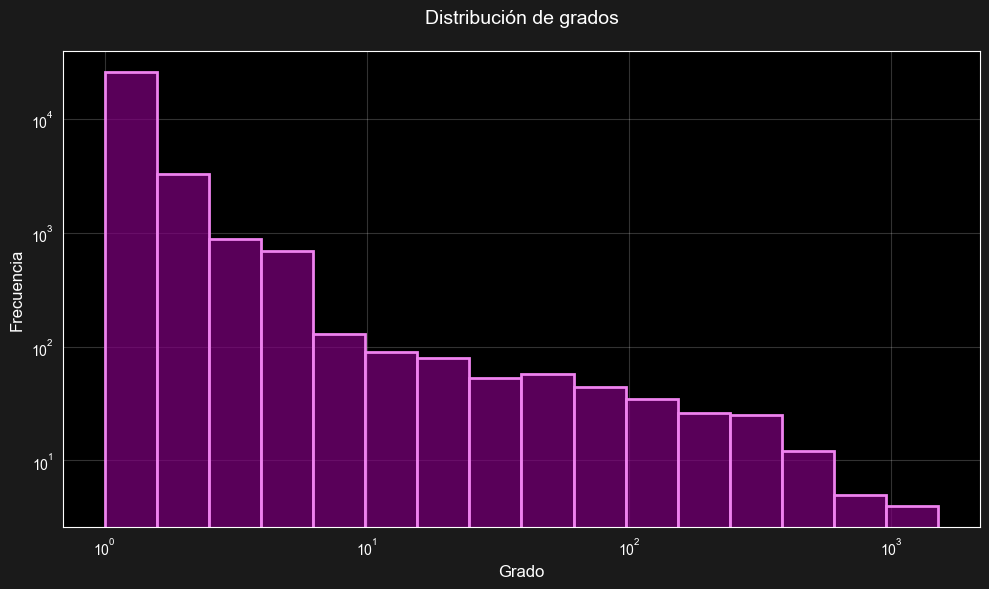

In [ ]:
degrees = [d for _, d in G.degree()]
plt.figure(figsize=(10, 6), facecolor='#1a1a1a')
plt.style.use('dark_background')
sns.histplot(data=degrees, kde=False, color='purple', alpha=0.7,
             edgecolor='violet', log_scale=True, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.xticks([1, 10, 100, 1000], color='white')
plt.yticks(color='white')
plt.title("Distribución de grados", color='white', size=14, pad=20)
plt.xlabel("Grado", color='white', size=12)
plt.ylabel("Frecuencia", color='white', size=12)
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()


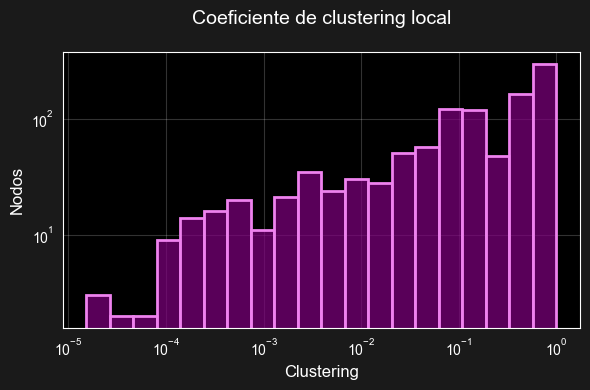

Clustering medio: 0.0124


In [ ]:
clust_coef = nx.clustering(G)
df_clust = pd.Series(clust_coef, name='clustering')
plt.figure(figsize=(6, 4), facecolor='#1a1a1a')
plt.style.use('dark_background')
sns.histplot(df_clust, kde=False, edgecolor='violet', color='purple', alpha=0.7, log_scale=True, linewidth=2)
plt.xscale('log')
plt.yscale('log')
plt.title("Coeficiente de clustering local", color='white', size=14, pad=20)
plt.xlabel("Clustering", color='white', size=12)
plt.ylabel("Nodos", color='white', size=12)
plt.xticks(color='white')
plt.yticks(color='white')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.show()

print(f"Clustering medio: {df_clust.mean():.4f}")


### Análisis de Coeficientes de Clustering

Este documento explica el significado de los coeficientes de clustering local en tu red de Reddit y cómo interpretarlos a nivel de usuarios y comunidades.

---

#### ¿Qué es el coeficiente de clustering local?

El **coeficiente de clustering local** mide la probabilidad de que dos “vecinos” de un nodo (usuario) también estén conectados entre sí:

- `0` → Ninguno de sus contactos interactúa entre sí.  
- `1` → Todos sus contactos están conectados en un mismo grupo.  
- `(0, 1)` → Grado de cohesión intermedio.

---

#### Interpretación del histograma

- **Eje X (Clustering)**: escala logarítmica de ~10<sup>–5</sup> a 1.  
- **Eje Y (Nodos)**: número de usuarios en cada intervalo (también en escala logarítmica).

---

#### ¿Qué nos revela tu red de Reddit?

##### 1. Usuarios “puente” (clustering bajo)
- Gran cantidad de usuarios con valores cercanos a `0`.  
- Conectan distintas comunidades, pero sus contactos no se conocen entre sí.  
- Clave para **difundir información** de un subreddit a otro.

##### 2. Comunidades cerradas (clustering alto)
- Grupo menor, pero significativo, con valores próximos a `1`.  
- Todos interactúan entre sí, formando núcleos muy cohesionados.  
- Facilitan la **viralidad interna**, disparando rápidamente ciertos contenidos.

---

#### Conclusiones

- Un **alto número de nodos** con clustering bajo sugiere una red abierta, ideal para alcance masivo.  
- La **presencia de núcleos densos** indica subreddits con discusiones intensas y viralidad local.  
- Este análisis te ayudará a:
  - Identificar **influencers puente** para campañas de difusión.  
  - Detectar **subcomunidades** con alta cohesión para acciones focalizadas.  
  - Equilibrar estrategias de alcance y profundidad de comunidad.  


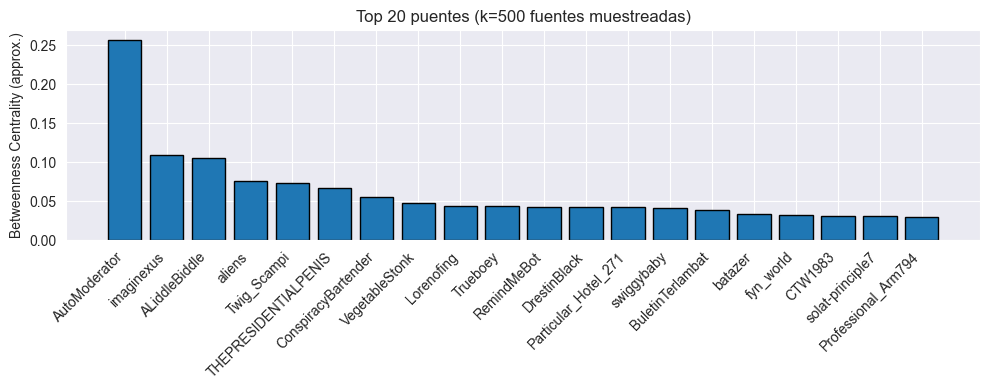

In [ ]:
if not nx.is_connected(G):
    cc = max(nx.connected_components(G), key=len)
    G = G.subgraph(cc).copy()


n = G.number_of_nodes()

k = min(500, n)
random.seed(42) 
bc = nx.betweenness_centrality(G, k=k, normalized=True, seed=42)

top20 = sorted(bc.items(), key=lambda x: x[1], reverse=True)[:20]
nodes, scores = zip(*top20)

plt.figure(figsize=(10,4))
plt.bar([str(u) for u in nodes], scores, edgecolor='black')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Betweenness Centrality (approx.)')
plt.title(f'Top 20 puentes (k={k} fuentes muestreadas)')
plt.tight_layout()
plt.show()

### Top 20 Puentes de Información

**Betweenness centrality** mide la frecuencia con la que un usuario actúa como “puente” en las rutas más cortas entre pares de nodos.

#### Hallazgos clave

- **AutoModerator (≈0.25)**  
  Principal conector, presente en una gran cantidad de caminos entre usuarios.  
- **imaginexus, AttcleBirdle, aliens… (0.10–0.07)**  
  Usuarios con alta capacidad para enlazar distintas comunidades.  
- **Resto del Top 20 (0.06–0.03)**  
  Puentes secundarios pero relevantes para la difusión.

#### Implicaciones

- **Maximizar alcance**  
  Colaborar o difundir contenido vía estos nodos potenciará la propagación.  
- **Mapeo de comunidades**  
  Identificar estos usuarios ayuda a entender y optimizar el flujo de información entre subreddits.


In [ ]:
cliques = list(nx.find_cliques(G))
print(f"Número total de cliques encontradas: {len(cliques)}")
max_clique_size = max(len(c) for c in cliques)
print(f"Tamaño de la clique máxima: {max_clique_size}")

Número total de cliques encontradas: 39113
Tamaño de la clique máxima: 5


### Significado de las cliques

- **Clique**: subgrupo de nodos donde cada par está conectado.  
- **39 113 cliques**: múltiples grupos cohesionados detectados.  
- **Tamaño máximo = 5**: el mayor núcleo completo engloba 5 usuarios.  
- **Interpretación**: existen numerosos pequeños “círculos cerrados” en la red, reflejando comunidades muy unidas.  


In [ ]:
partition = community_louvain.best_partition(G)
mod = community_louvain.modularity(partition, G)
print(f"Comunidades detectadas: {len(set(partition.values()))}")
print(f"Modularidad (Louvain): {mod:.3f}")

Comunidades detectadas: 45
Modularidad (Louvain): 0.814


### Significado de las comunidades
- Grupos de nodos con conexión intensa.
- **45 detectadas**: variedad de grupos temáticos bien diferenciados, más de los 10 subreddit estudiados.  
- **Modularidad 0.814**: particiones muy definidas — fuerte cohesión interna y escasas conexiones externas, los usuarios interactúan con sus 'contactos' que con otros.  

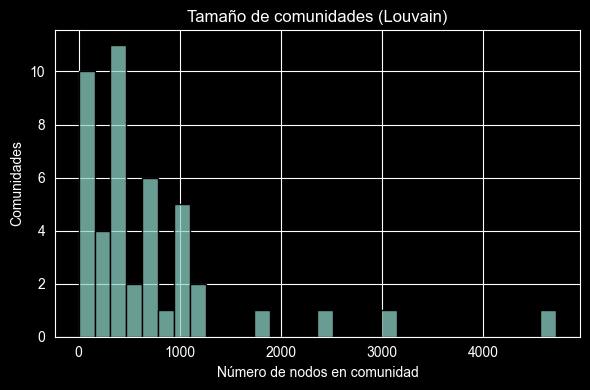

In [ ]:
# Histograma de tamaños de comunidad
com_sizes = pd.Series(list(partition.values())).value_counts()
plt.figure(figsize=(6,4))
sns.histplot(com_sizes, bins=30, kde=False, edgecolor='black')
plt.title("Tamaño de comunidades (Louvain)")
plt.xlabel("Número de nodos en comunidad")
plt.ylabel("Comunidades")
plt.tight_layout()
plt.show()

#### Comparativo de Comunidades Reddit

1. **Subgrafos por subreddit**  
   Extraemos nodos y aristas que comparten etiqueta `subreddit`.

2. **Cálculo de métricas**  
   Para cada subgrafo obtenemos:  
   - Tamaño (nodos)  
   - Conexiones (aristas)  
   - Grado promedio  
   - Densidad  
   - Clustering

3. **Visualización 2×2**  
   Barras para:  
   - Número de usuarios  
   - Grado promedio  
   - Densidad interna  
   - Coeficiente de clustering

> Permite comparar tamaño y cohesión de cada comunidad.  


C:\Users\iocol\AppData\Local\Temp\ipykernel_2236\979590809.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x='subreddit', y='nodos', ax=axes[0, 0], palette='viridis')
C:\Users\iocol\AppData\Local\Temp\ipykernel_2236\979590809.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x='subreddit', y='grado_promedio', ax=axes[0, 1], palette='magma')
C:\Users\iocol\AppData\Local\Temp\ipykernel_2236\979590809.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_metricas, x='subreddit', y='densidad', a

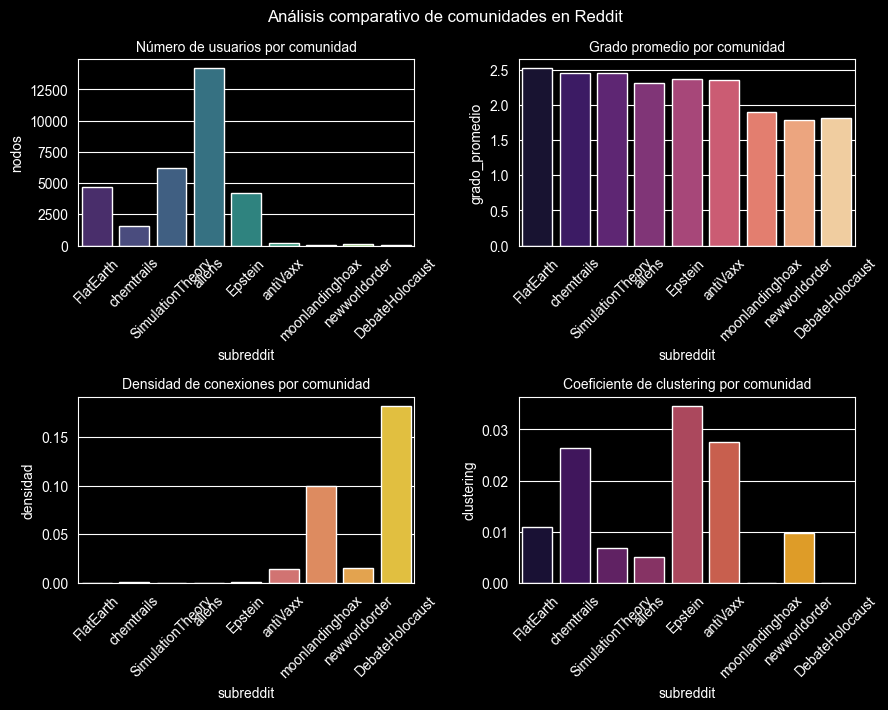

In [ ]:
import seaborn as sns
import pandas as pd

subgrafos = {}

# subgrafos para cada subreddit
for nodo in grafo.nodes():
    subreddit = grafo.nodes[nodo].get('subreddit', None)
    if subreddit:
        if subreddit not in subgrafos:
            subgrafos[subreddit] = nx.Graph()
        subgrafos[subreddit].add_node(nodo)


for u, v in grafo.edges():
    subreddit_u = grafo.nodes[u].get('subreddit', None)
    subreddit_v = grafo.nodes[v].get('subreddit', None)
    if subreddit_u and subreddit_u == subreddit_v:
        subgrafos[subreddit_u].add_edge(u, v)

# DataFrame para almacenar las métricas de cada subreddit
metricas = []
for subreddit, subgrafo in subgrafos.items():
    grados = [d for _, d in subgrafo.degree()]
    metricas.append({
        'subreddit': subreddit,
        'nodos': subgrafo.number_of_nodes(),
        'aristas': subgrafo.number_of_edges(),
        'grado_promedio': sum(grados) / len(grados) if grados else 0,
        'densidad': nx.density(subgrafo),
        'clustering': nx.average_clustering(subgrafo)
    })

df_metricas = pd.DataFrame(metricas)

# varios subplots para las diferentes métricas
plt.style.use('dark_background')
fig, axes = plt.subplots(2, 2, figsize=(9, 7.2))  
fig.suptitle('Análisis comparativo de comunidades en Reddit', fontsize=12, y=0.98)  

# barras para el número de nodos
sns.barplot(data=df_metricas, x='subreddit', y='nodos', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Número de usuarios por comunidad', fontsize=10)  # Reduced from default
axes[0, 0].tick_params(axis='x', rotation=45)

# barras para el grado promedio
sns.barplot(data=df_metricas, x='subreddit', y='grado_promedio', ax=axes[0, 1], palette='magma')
axes[0, 1].set_title('Grado promedio por comunidad', fontsize=10)
axes[0, 1].tick_params(axis='x', rotation=45)

# barras para la densidad
sns.barplot(data=df_metricas, x='subreddit', y='densidad', ax=axes[1, 0], palette='plasma')
axes[1, 0].set_title('Densidad de conexiones por comunidad', fontsize=10)
axes[1, 0].tick_params(axis='x', rotation=45)

# barras para el clustering
sns.barplot(data=df_metricas, x='subreddit', y='clustering', ax=axes[1, 1], palette='inferno')
axes[1, 1].set_title('Coeficiente de clustering por comunidad', fontsize=10)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


#### Heatmap de solapamiento

Calcularemos un heatmap con el número de usuarios compartidos entre cada par de comunidades.  
Esto nos permitirá:

- Destacar solapamientos clave.  
- Justificar la cercanía de los nodos en el grafo.  

In [ ]:

# Encontrar las aristas entre diferentes subreddits
conexiones_entre_subreddits = []
for u, v in grafo.edges():
    subreddit_u = grafo.nodes[u].get('subreddit', None)
    subreddit_v = grafo.nodes[v].get('subreddit', None)

    if subreddit_u and subreddit_v and subreddit_u != subreddit_v:
        conexiones_entre_subreddits.append((subreddit_u, subreddit_v))

# Crear DataFrame con las conexiones
df_conexiones = pd.DataFrame(conexiones_entre_subreddits, columns=['subreddit1', 'subreddit2'])

# Contar frecuencias de conexiones
conexiones_count = df_conexiones.groupby(['subreddit1', 'subreddit2']).size().reset_index(name='count')
conexiones_count = conexiones_count.sort_values('count', ascending=False)

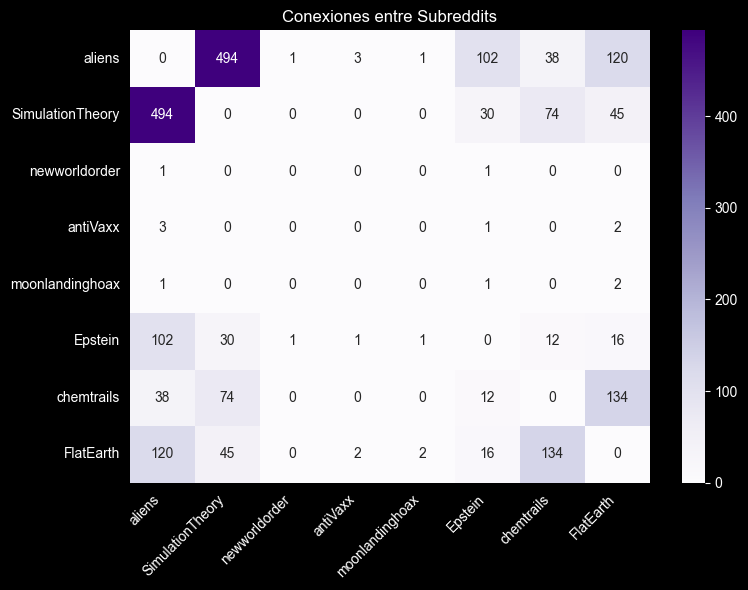

In [ ]:
# matriz de adyacencia para el heatmap
subreddits_unicos = list(set(conexiones_count['subreddit1'].unique()) | set(conexiones_count['subreddit2'].unique()))
matriz_adj = pd.DataFrame(0, index=subreddits_unicos, columns=subreddits_unicos)

for _, row in conexiones_count.iterrows():
    matriz_adj.loc[row['subreddit1'], row['subreddit2']] = row['count']
    matriz_adj.loc[row['subreddit2'], row['subreddit1']] = row['count']

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_adj, annot=True, cmap='Purples', fmt='.0f')
plt.title('Conexiones entre Subreddits')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
print("\nTop 20 conexiones más fuertes entre subreddits:")
print(conexiones_count.head(20))


Top 20 conexiones más fuertes entre subreddits:
          subreddit1        subreddit2  count
13  SimulationTheory            aliens    910
17            aliens  SimulationTheory    494
16            aliens         FlatEarth    419
24        chemtrails         FlatEarth    144
2            Epstein            aliens    139
10         FlatEarth        chemtrails    134
8          FlatEarth            aliens    120
14  SimulationTheory        chemtrails    114
15            aliens           Epstein    102
1            Epstein  SimulationTheory     95
25        chemtrails  SimulationTheory     74
7          FlatEarth  SimulationTheory     56
19            aliens        chemtrails     50
12  SimulationTheory         FlatEarth     45
6          FlatEarth           Epstein     43
26        chemtrails            aliens     38
11  SimulationTheory           Epstein     30
0            Epstein         FlatEarth     16
23        chemtrails           Epstein     13
4            Epstein        che

### Características Principales del Grafo

| Métrica | Valor |
|---------|-------|
| Número de Nodos | 31,116 |
| Número de Aristas | 40,704 |
| Densidad | 0.000084 |
| Grado Promedio | 2.62 |
| Coeficiente de Clustering Promedio | 0.017 |
| Número de Comunidades | 41 |
| Modularidad | 0.814 |
| Componentes Conectados | múltiples |

#### Observaciones Principales

1. **Estructura General**:
   - El grafo es disperso (densidad muy baja)
   - Presenta una estructura de comunidades bien definida (alta modularidad)
   - El grado promedio indica que cada usuario interactúa con ~2-3 otros usuarios

2. **Comunidades**:
   - Se identificaron 45 comunidades distintas
   - La modularidad de 0.814 indica una fuerte estructura comunitaria y de nicho.

3. **Conectividad**:
   - El grafo no es completamente conexo
   - Los subreddits muestran diferentes patrones de conexión entre sí

4. **Clustering**:
   - El bajo coeficiente de clustering (0.017) sugiere poca tendencia a formar grupos cerrados
   - Varía significativamente entre diferentes subreddits
